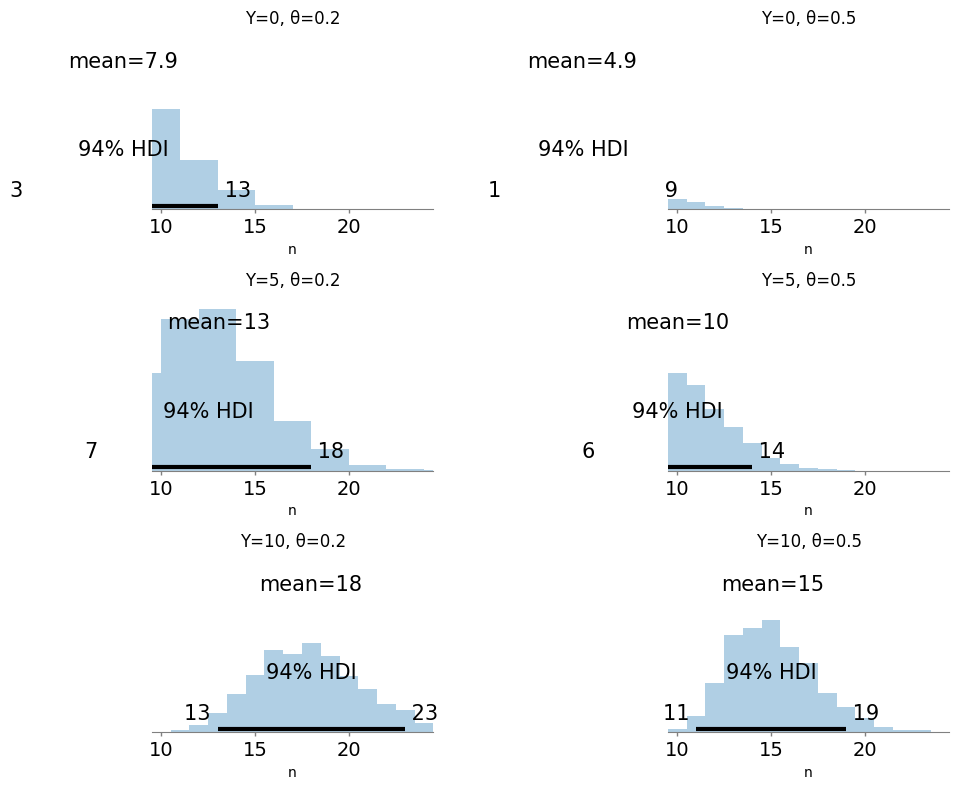

Y= 0, θ=0.2 -> E[n|Y]≈7.95, 94% HDI≈[3.00, 13.00]
Y= 0, θ=0.5 -> E[n|Y]≈4.93, 94% HDI≈[1.00, 9.00]
Y= 5, θ=0.2 -> E[n|Y]≈13.09, 94% HDI≈[7.00, 18.00]
Y= 5, θ=0.5 -> E[n|Y]≈10.05, 94% HDI≈[6.00, 14.00]
Y=10, θ=0.2 -> E[n|Y]≈17.99, 94% HDI≈[13.00, 23.00]
Y=10, θ=0.5 -> E[n|Y]≈15.09, 94% HDI≈[11.00, 19.00]


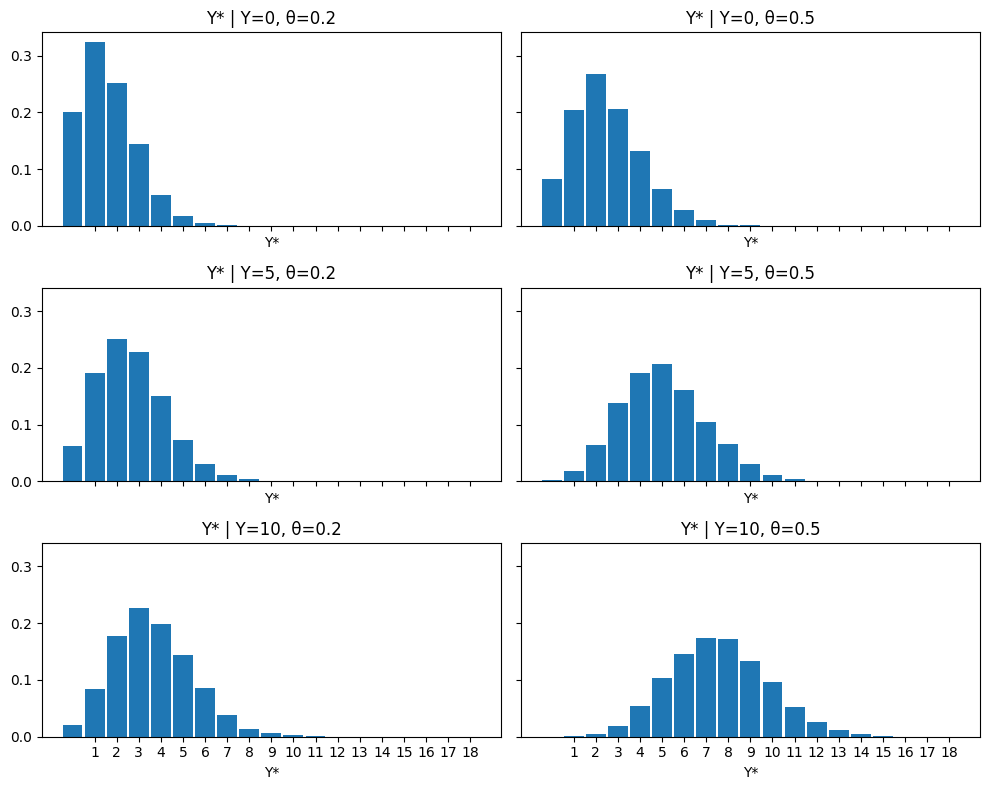

In [1]:
!pip install pymc arviz matplotlib

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

Y_values = [0, 5, 10]
theta_values = [0.2, 0.5]
mu_prior_n = 10
RANDOM_SEED = 2025

idatas = {}
posteriors_n = {}

# a) Posterior pentru n pentru toate combinatiile (Y, theta) si plot cu az.plot_posterior
for y_obs in Y_values:
    for theta in theta_values:
        key = (y_obs, theta)
        with pm.Model() as model:
            n = pm.Poisson("n", mu=mu_prior_n)
            y = pm.Binomial("y", n=n, p=theta, observed=y_obs)
            y_future = pm.Binomial("y_future", n=n, p=theta)

            step = pm.Metropolis()

            idata = pm.sample(
                draws=4000,
                tune=4000,
                chains=2,
                cores=1,
                step=step,
                random_seed=RANDOM_SEED,
                progressbar=False,
            )

            idata = pm.sample_posterior_predictive(
                idata,
                model=model,
                var_names=["y_future"],
                extend_inferencedata=True,
                random_seed=RANDOM_SEED,
                progressbar=False,
            )

        idatas[key] = idata
        posteriors_n[key] = idata.posterior["n"]

fig, axes = plt.subplots(
    len(Y_values),
    len(theta_values),
    figsize=(10, 8),
    sharex=True,
    sharey=True,
)

for i, y_obs in enumerate(Y_values):
    for j, theta in enumerate(theta_values):
        ax = axes[i, j]
        key = (y_obs, theta)
        az.plot_posterior(posteriors_n[key], hdi_prob=0.94, ax=ax)
        ax.set_title(f"Y={y_obs}, θ={theta}")
        ax.set_xlabel("n")

plt.tight_layout()
plt.show()

# b) Y mai mare muta posteriorul lui n spre valori mai mari; θ mai mare muta posteriorul lui n spre valori mai mici (pentru acelasi Y).

for y_obs in Y_values:
    for theta in theta_values:
        key = (y_obs, theta)
        summary_n = az.summary(idatas[key], var_names=["n"], hdi_prob=0.94)
        mean_n = summary_n.loc["n", "mean"]
        hdi_low = summary_n.loc["n", "hdi_3%"]
        hdi_high = summary_n.loc["n", "hdi_97%"]
        print(
            f"Y={y_obs:2d}, θ={theta:.1f} -> E[n|Y]≈{mean_n:.2f}, "
            f"94% HDI≈[{hdi_low:.2f}, {hdi_high:.2f}]"
        )

# c) Distributia predictiva a posteriori pentru Y* pentru fiecare scenariu, vizualizata cu az.plot_dist

fig, axes = plt.subplots(
    len(Y_values),
    len(theta_values),
    figsize=(10, 8),
    sharex=True,
    sharey=True,
)

for i, y_obs in enumerate(Y_values):
    for j, theta in enumerate(theta_values):
        ax = axes[i, j]
        key = (y_obs, theta)
        y_future_samples = idatas[key].posterior_predictive["y_future"]
        az.plot_dist(y_future_samples, ax=ax)
        ax.set_title(f"Y* | Y={y_obs}, θ={theta}")
        ax.set_xlabel("Y*")

plt.tight_layout()
plt.show()

# d) Posteriorul p(n|Y) descrie incertitudinea despre numarul total de clienti n; predictiva p(Y*|Y)
#    integreaza peste n si da distributia viitorului numar de cumparatori Y*, de obicei mai lata/mai difuza.


## (b) Efectul lui Y și θ asupra posteriorului pentru n

- **Efectul lui Y**  
  - Când **Y crește**, posteriorul pentru \(n\) se mută spre valori **mai mari**.  
    Intuiție: ca să avem mai mulți cumpărători, în medie trebuie să fi existat mai mulți clienți în total.  
  - Pentru **Y = 0**, distribuția lui \(n\) favorizează valori relativ **mici** (e greu să ai foarte mulți clienți și niciunul să nu cumpere).

- **Efectul lui θ**  
  - Pentru **θ mai mare (0.5)**, posteriorul pentru \(n\) se mută spre valori **mai mici**: dacă fiecare client are o probabilitate mare să cumpere, nu avem nevoie de foarte mulți clienți ca să explicăm același Y.  
  - Pentru **θ mai mic (0.2)**, posteriorul pentru \(n\) se mută spre valori **mai mari**: cu șansa mică de cumpărare trebuie, în medie, mai mulți clienți ca să obținem același Y.

Pe scurt:  
- **Y mai mare → n posterior mai mare**  
- **θ mai mare → n posterior mai mic** (pentru același Y)

---

## (d) Posteriorul pentru n vs. predictive posterior pentru Y\*

- **Posteriorul pentru n, \(p(n \mid Y, \theta)\)**  
  - Este distribuția a posteriori a **numărului total de clienți** în ziua observată.  
  - Descrie incertitudinea noastră despre parametrul latent \(n\) după ce am văzut \(Y\).

- **Distribuția predictivă a posteriori pentru \(Y^\*\), \(p(Y^\* \mid Y, \theta)\)**  
  - Este distribuția pentru **viitorul număr de cumpărători** într-o zi similară.  
  - Se obține prin integrare peste incertitudinea în \(n\):  
    \[
    p(Y^\* \mid Y, \theta) = \int p(Y^\* \mid n, \theta)\, p(n \mid Y, \theta)\, dn
    \]
  - Adică mai întâi tragem mostre de \(n\) din posterior, apoi generăm \(Y^\*\) din Binomial(\(n, \theta\)).

Diferență esențială:
- Posteriorul pentru \(n\) este despre **parametru** (câți clienți au fost în ziua observată).
- Predictiva pentru \(Y^\*\) este despre **date viitoare** (câți vor cumpăra într-o nouă zi), deci include și incertitudinea în \(n\) și de aceea e de obicei mai „lată”/mai difuză decât un simplu Binomial cu un \(n\) fix.
